In [2]:
import h5py
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_2d
from scipy.interpolate import make_splprep

In [4]:
f = h5py.File('/sdf/home/s/seohyeon/summer25/testing/raw_data/muon1k_0-1gev_gampix_raw_run0.h5')
pixels = f['pixel_hits']
coarse = f['coarse_hits']
meta = f['meta']

print(len(meta['primary energy']))
ev_n = 2

ev_mask_pixels = pixels['event id'] == ev_n
ev_pixels = pixels[ev_mask_pixels]


points = np.array([[hit['pixel x'], hit['pixel y'], hit['hit z']] for hit in ev_pixels])
charge = ev_pixels['hit charge']
    

1000


In [5]:
# pca ------------
min_hits = 80
if len(points) < min_hits:
    print(len(points))
    print('not enough hits in this event')
    sys.exit()
else:
    pca = PCA(n_components = 3)
    pca_on_hits = pca.fit(points)
    principal=pca.components_[0] #this is a unit vector


projections ={}
for pt in points:
    mag_proj = np.dot(principal, pt) #signed projection scalar
    projections[mag_proj] = pt


start = projections[min(projections)]
stop = projections[max(projections)]
start = np.array(start)
stop = np.array(stop)

naive_length = max(projections) - min(projections)
naive_vector = (stop - start) * naive_length / np.linalg.norm(stop - start)

In [6]:
bins1d = 5
statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    points[:, 0], points[:, 1], points[:, 2], statistic='mean', bins=(bins1d, bins1d))


# calculating the weighted avg of each bin
weighted_avgs = {}
for bin_n in range(max(binnumber)+1):
    indices = np.where(binnumber==bin_n)
    indices = indices[0]
    
    bin_points = points[indices]
    bin_charges = charge[indices]

    if len(bin_points) == 0:
        continue
        
    weighted_avg = 0
    num = 0
    denom = 0

    
    for i, pt in enumerate(bin_points):
        num += pt[2] * bin_charges[i]
    for val in bin_charges:
        denom += val
        
    weighted_avg = num / denom

    if np.isnan(weighted_avg) == True:
        continue
    else:
        weighted_avgs[bin_n] = weighted_avg


# calculating avg x and y values of each bin
spl_pts=[]
for bin_n in weighted_avgs.keys():
    indices = np.where(binnumber==bin_n)
    indices = indices[0]
    
    bin_points = points[indices]

    x_avg = 0
    y_avg = 0
    n = len(bin_points)

    for pt in bin_points:
        x_avg += pt[0]
        y_avg += pt[1]
        
    x_avg = x_avg / n
    y_avg = y_avg / n


    spl_pt = [x_avg, y_avg, weighted_avgs[bin_n]]
    spl_pts.append(spl_pt)

In [8]:
# sort binned points for spline
spl_pts = np.array(spl_pts)


dist_from_start = []
for pt in spl_pts:
    dist_from_start.append(np.linalg.norm(pt - start))

sorted_indices = np.argsort(dist_from_start)
spl_pts = spl_pts[sorted_indices]


# add start and stop points to spline points
start_index = np.where(np.all(points == start, axis = 1))[0]
stop_index = np.where(np.all(points == stop, axis = 1))[0]
spl_pts = np.insert(spl_pts, 0, start, axis=0)
spl_pts = np.vstack([spl_pts, stop])

# weight start and stop points so spline is clamped
clamp_weights = np.ones(len(spl_pts) - 2)
clamp_weights = np.insert(clamp_weights, 0, 1000)
clamp_weights = np.append(clamp_weights, 1000)


#spline 
spline, u = make_splprep([spl_pts[:, 0], spl_pts[:, 1], spl_pts[:, 2]], s=25, w=clamp_weights)
u_fine = np.linspace(0, 1, 1000)
x_fine, y_fine, z_fine = spline(u_fine)


# arc length of spline
arc = 0
u_ultrafine = np.linspace(0, 1, 5000)
for i, u in enumerate(u_ultrafine):
    if i == 0 :
        continue
    else:
        u_prev = u_ultrafine[i-1]        
        arc += np.linalg.norm(spline(u) - spline(u_prev))

print(f'naive length: {naive_length}')
print(f'detailed length: {arc}')
if naive_length > arc:
    print('naive > detailed!')

naive length: 348.5267333984375
detailed length: 482.3275329260375


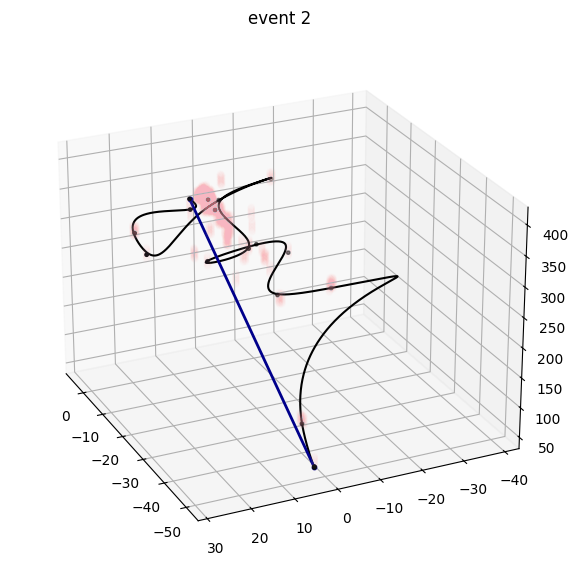

In [9]:
# plotting
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_title(f'event {ev_n}')
ax.view_init(elev=24.7, azim=155)

ax.scatter(spl_pts[:, 0], spl_pts[:, 1], spl_pts[:, 2], color='black', s=6)
ax.scatter(points[:,0], points[:,1], points[:,2], 'o', s=20, color='lightpink', alpha = 0.01) # gampix points
plt.plot(x_fine, y_fine, z_fine, color='black') # spline curve
ax.scatter(*start, 'o', color='darkblue', s=10) 
ax.scatter(*stop, 'o', color='darkblue', s=10)
ax.quiver(*start, *naive_vector, arrow_length_ratio = 0.001, color='darkblue', linewidths=2)

